<a href="https://colab.research.google.com/github/Voidmort/Study-Notes-TensorFlow/blob/master/TensorFlow_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: TensorFlow 6
date: 2019-01-14 10:10:00
tags: Tensorflow
categories: Tensorflow
---

# 特征组合 (Feature Crosses)

特征组合是指两个或多个特征相乘形成的合成特征。特征的相乘组合可以提供超出这些特征单独能够提供的预测能力。

## 对非线性规律进行编码



## 组合独热矢量

到目前为止，我们已经重点介绍了如何对两个单独的浮点特征进行特征组合。在实践中，机器学习模型很少会组合连续特征。不过，机器学习模型却经常组合独热特征矢量，将独热特征矢量的特征组合视为逻辑连接。例如，假设我们具有以下两个特征：国家/地区和语言。对每个特征进行独热编码会生成具有二元特征的矢量，这些二元特征可解读为 country=USA, country=France 或 language=English, language=Spanish。然后，如果您对这些独热编码进行特征组合，则会得到可解读为逻辑连接的二元特征，如下所示：

      country:usa AND language:spanish
再举一个例子，假设您对纬度和经度进行分箱，获得单独的独热 5 元素特征矢量。例如，指定的纬度和经度可以表示如下：

      binned_latitude = [0, 0, 0, 1, 0]
      binned_longitude = [0, 1, 0, 0, 0]
假设您对这两个特征矢量创建了特征组合：

    binned_latitude X binned_longitude
此特征组合是一个 25 元素独热矢量（24 个 0 和 1 个 1）。该组合中的单个 1 表示纬度与经度的特定连接。然后，您的模型就可以了解到有关这种连接的特定关联性。

假设我们更粗略地对纬度和经度进行分箱，如下所示：

    binned_latitude(lat) = [
      0  < lat <= 10
      10 < lat <= 20
      20 < lat <= 30
    ]

    binned_longitude(lon) = [
      0  < lon <= 15
      15 < lon <= 30
    ]
针对这些粗略分箱创建特征组合会生成具有以下含义的合成特征：

    binned_latitude_X_longitude(lat, lon) = [
      0  < lat <= 10 AND 0  < lon <= 15
      0  < lat <= 10 AND 15 < lon <= 30
      10 < lat <= 20 AND 0  < lon <= 15
      10 < lat <= 20 AND 15 < lon <= 30
      20 < lat <= 30 AND 0  < lon <= 15
      20 < lat <= 30 AND 15 < lon <= 30
    ]
现在，假设我们的模型需要根据以下两个特征来预测狗主人对狗狗的满意程度：

行为类型（吠叫、叫、偎依等）
时段
如果我们根据这两个特征构建以下特征组合：

      [behavior type X time of day]
      
我们最终获得的预测能力将远远超过任一特征单独的预测能力。例如，如果狗狗在下午 5 点主人下班回来时（快乐地）叫喊，可能表示对主人满意度的正面预测结果。如果狗狗在凌晨 3 点主人熟睡时（也许痛苦地）哀叫，可能表示对主人满意度的强烈负面预测结果。

线性学习器可以很好地扩展到大量数据。对大规模数据集使用特征组合是学习高度复杂模型的一种有效策略。神经网络可提供另一种策略。

# 编程练习

  * 通过添加其他合成特征来改进线性回归模型（这是前一个练习的延续）
  * 使用输入函数将 Pandas `DataFrame` 对象转换为 `Tensors`，并在 `fit()` 和 `predict()` 中调用输入函数
  * 使用 FTRL 优化算法进行模型训练
  * 通过独热编码、分箱和特征组合创建新的合成特征


 ## 设置
  
 首先，我们来定义输入并创建数据加载代码，正如我们在之前的练习中所做的那样。

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2643.5,539.4,1430.0,501.4,3.9,2.0
std,2.1,2.0,12.6,2203.2,423.9,1153.9,388.0,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1457.8,295.0,788.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2121.0,432.0,1165.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3149.2,647.0,1717.0,603.2,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.7,2644.1,539.3,1428.5,500.7,3.9,2.0
std,2.1,2.0,12.6,2123.4,415.6,1133.3,376.0,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1473.0,300.0,792.0,285.0,2.6,1.5
50%,34.3,-118.5,29.0,2148.5,437.0,1172.0,413.5,3.5,2.0
75%,37.7,-118.0,37.0,3153.2,652.2,1737.0,608.0,4.8,2.3
max,42.0,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,207.6
std,116.2
min,15.0
25%,119.8
50%,180.4
75%,265.7
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.5
std,115.6
min,15.0
25%,118.8
50%,180.1
75%,263.4
max,500.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## FTRL 优化算法

高维度线性模型可受益于使用一种基于梯度的优化方法，叫做 FTRL。该算法的优势是针对不同系数以不同方式调整学习速率，如果某些特征很少采用非零值，该算法可能比较实用（也非常适合支持 L1 正则化）。我们可以使用 [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer) 来应用 FTRL。

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 180.73
  period 01 : 170.12
  period 02 : 111.43
  period 03 : 157.79
  period 04 : 147.28
  period 05 : 139.07
  period 06 : 120.82
  period 07 : 148.39
  period 08 : 118.07
  period 09 : 117.32
Model training finished.


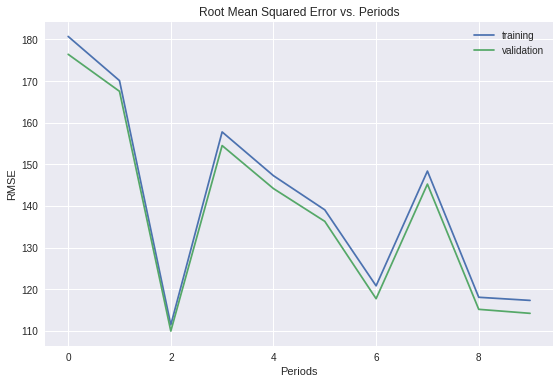

In [7]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 离散特征的独热编码

通常，在训练逻辑回归模型之前，离散（即字符串、枚举、整数）特征会转换为二元特征系列。

例如，假设我们创建了一个合成特征，可以采用 `0`、`1` 或 `2` 中的任何值，并且我们还具有以下几个训练点：

|  | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

对于每个可能的分类值，我们都会创建一个新的**二元实值**特征，该特征只能采用两个可能值中的一个：如果示例中包含该值，则值为 1.0；如果不包含，则值为 0.0。在上述示例中，分类特征会被转换成三个特征，现在训练点如下所示：

|  | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

 ## 分桶（分箱）特征

分桶也称为分箱。

例如，我们可以将 `population` 分为以下 3 个分桶：
- `bucket_0` (`< 5000`)：对应于人口分布较少的街区
- `bucket_1` (`5000 - 25000`)：对应于人口分布适中的街区
- `bucket_2` (`> 25000`)：对应于人口分布较多的街区

根据前面的分桶定义，以下 `population` 矢量：

    [[10001], [42004], [2500], [18000]]

将变成以下经过分桶的特征矢量：

    [[1], [2], [0], [1]]

这些特征值现在是分桶索引。请注意，这些索引被视为离散特征。通常情况下，这些特征将被进一步转换为上述独热表示法，但这是以透明方式实现的。

要为分桶特征定义特征列，我们可以使用 [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column)（而不是使用 `numeric_column`），该列将数字列作为输入，并使用 `boundaries` 参数中指定的分桶边界将其转换为分桶特征。以下代码为 `households` 和 `longitude` 定义了分桶特征列；`get_quantile_based_boundaries` 函数会根据分位数计算边界，以便每个分桶包含相同数量的元素。

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]
 
# 把 households 分成7桶
households = tf.feature_column.numeric_column("housholds")
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["households"], 7))

# 把 longitude 分成10桶
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["longitude"], 10))

 ## 任务 1：使用分桶特征列训练模型
**将我们示例中的所有实值特征进行分桶，训练模型，然后查看结果是否有所改善。**

在前面的代码块中，两个实值列（即 `households` 和 `longitude`）已被转换为分桶特征列。您的任务是对其余的列进行分桶，然后运行代码来训练模型。您可以采用各种启发法来确定分桶的范围。本练习使用了分位数技巧，通过这种方式选择分桶边界后，每个分桶将包含相同数量的样本。

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 169.83
  period 01 : 143.51
  period 02 : 126.97
  period 03 : 115.77
  period 04 : 107.83
  period 05 : 101.97
  period 06 : 97.44
  period 07 : 93.81
  period 08 : 90.89
  period 09 : 88.49
Model training finished.


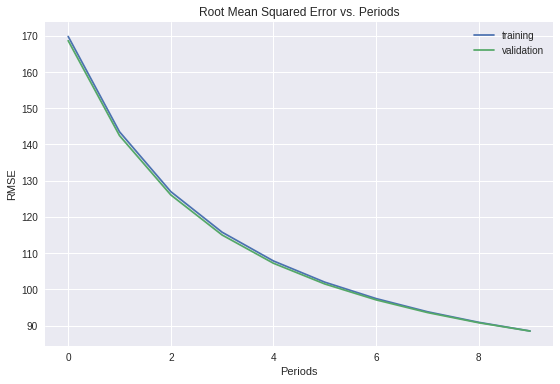

In [10]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 特征组合

组合两个（或更多个）特征是使用线性模型来学习非线性关系的一种聪明做法。在我们的问题中，如果我们只使用 `latitude` 特征进行学习，那么该模型可能会发现特定纬度（或特定纬度范围内，因为我们已经将其分桶）的城市街区更可能比其他街区住房成本高昂。`longitude` 特征的情况与此类似。但是，如果我们将 `longitude` 与 `latitude` 组合，产生的组合特征则代表一个明确的城市街区。如果模型发现某些城市街区（位于特定纬度和经度范围内）更可能比其他街区住房成本高昂，那么这将是比单独考虑两个特征更强烈的信号。

目前，特征列 API 仅支持组合离散特征。要组合两个连续的值（比如 `latitude` 或 `longitude`），我们可以对其进行分桶。

如果我们组合 `latitude` 和 `longitude` 特征（例如，假设 `longitude` 被分到 `2` 个分桶中，而 `latitude` 有 `3` 个分桶），我们实际上会得到 6 个组合的二元特征。当我们训练模型时，每个特征都会分别获得自己的权重。

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # 为long_x_lat feature cross做一个特性列
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 163.99
  period 01 : 135.79
  period 02 : 118.69
  period 03 : 107.28
  period 04 : 99.33
  period 05 : 93.53
  period 06 : 89.03
  period 07 : 85.54
  period 08 : 82.65
  period 09 : 80.32
Model training finished.


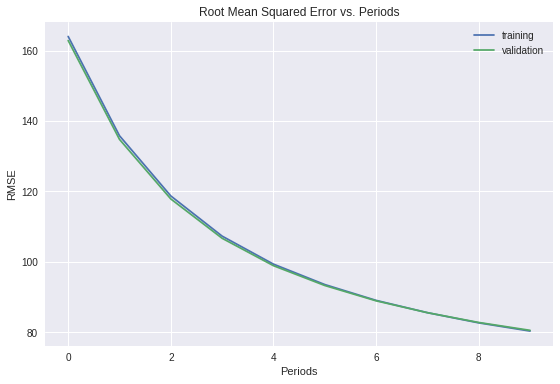

In [12]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)